<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Initialization" data-toc-modified-id="Initialization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Agent" data-toc-modified-id="Agent-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Agent</a></span><ul class="toc-item"><li><span><a href="#ReplayBuffer" data-toc-modified-id="ReplayBuffer-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>ReplayBuffer</a></span></li><li><span><a href="#Ornstein-Uhlenbeck-Process" data-toc-modified-id="Ornstein-Uhlenbeck-Process-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Ornstein-Uhlenbeck-Process</a></span></li><li><span><a href="#DDPG" data-toc-modified-id="DDPG-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DDPG</a></span><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Updates" data-toc-modified-id="Updates-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Updates</a></span><ul class="toc-item"><li><span><a href="#Critic" data-toc-modified-id="Critic-3.3.2.1"><span class="toc-item-num">3.3.2.1&nbsp;&nbsp;</span>Critic</a></span></li><li><span><a href="#Actor" data-toc-modified-id="Actor-3.3.2.2"><span class="toc-item-num">3.3.2.2&nbsp;&nbsp;</span>Actor</a></span></li></ul></li></ul></li><li><span><a href="#Code" data-toc-modified-id="Code-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Code</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Plotting-Trajectories" data-toc-modified-id="Plotting-Trajectories-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Plotting Trajectories</a></span></li></ul></li><li><span><a href="#Demo" data-toc-modified-id="Demo-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Demo</a></span><ul class="toc-item"><li><span><a href="#Simple-hardcoded-agent" data-toc-modified-id="Simple-hardcoded-agent-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Simple hardcoded agent</a></span></li></ul></li></ul></div>

*This notebook contains all the code and explanations that together make up our final project.*

# Introduction

At the ICLR 2016 (Lillicrap et al., 2016) published a paper called "Continuous Control with Deep Reinforcement Learning". In this paper the authors introduce a refined reinforcement learning algorithm named Deep Deterministic Policy Gradient ("DDPG"). Their reported results indicate that using the same hyperparamters, the DDPG agent robustly solves various physical control problems with continuous action spaces, outperforming a planning algorithm (Tassa et al., 2012) and DPG (Silver et al., 2014) on whose work DDPG is based. A basic reinforcement learning task which was not included in the report, is the continuous version of OpenAI's Mountain Car. In Mountain Car, an underpowered car has to climb a hill from a valley through leveraging the momentum generated by gravity.

<img src="img/mountain_climber.jpeg" height=20% width=20%>

Our project is a replication attempt of the 2016 report, focusing on the mountain car problem with a continuous action space. We will begin with writing a tensorflow2/keras implementation of the algorithm and using the exact same parameters as the authors did. Should the agent be inable to solve the problem, we will identify places for improvement and test wether the applied changes will yield a positive effect.

# Initialization

In [1]:
import numpy as np
import gym as gym
import tensorflow as tf
tf.keras.backend.set_floatx('float64') 

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
COLOR = 'cyan'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [3]:
import logging
logging.getLogger().setLevel(logging.INFO)

# Agent

In order to make sense out of our work, we provide a overview of the algorithm here, taken directly from (Lillicrapt et al. 2016).

<img src="img/ddpg_algorithm.png" style="height:65%;width:65%;" align="center">

At first glance it is nearly identical to DQN (Mnih et al. 2015). The only major difference lays in the actor update. The implementation of the actor and critic updates in tensorflow 2 will be the core challenge of our project. See <a href="#Training">training</a> for the high level implementation of this algorithm.

## ReplayBuffer

Let us begin with the prerequisites for the initialization of our agent. The first one is the replay buffer.

<img src="img/ddpg_algorithm_rp.png" style="height:50%;width:50%;" align="center" />

As we can see, the replay buffer only needs two functions. The first function 'store' serves to save memory tuples and the second function 'sample_batch' allows us to randomly sample a minibatch of tuples. We took ourselves the freedom to use a nicely optimized class from openai's github repo and made a tiny addition.

In [4]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for DDPG agents. 
    Source: 'https://github.com/openai/spinningup/blob/master/spinup/algos/ddpg/ddpg.py'
    """

    def __init__(self, obs_dim, act_dim, size):
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        # Our addition
        if len(obs.shape) > 1 or len(next_obs.shape) > 1:
            obs = np.reshape(obs, newshape=(-1,2))
        #
        
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=64):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(obs1=self.obs1_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    obs2=self.obs2_buf[idxs],
                    done=self.done_buf[idxs])

## Ornstein-Uhlenbeck-Process

The second prerequisite is a noise process to facilitate exploration. 

<img src="img/ddpg_algorithm_ou.png" style="height:50%;width:50%;" align="center" />

The authors chose an Ornstein-Uhlenbeck process to generate the noise required for exploration. According to them, it is a suitable choice for exploration in physical problems with momentum. The random values of the process are temporary correlated. The increment in the random variable $X$ with mean $\mu$ at time $t$, $dX_t$, is given by the following equation:

$$ dX_t = \theta (\mu - X_t)dt + \sigma dW_t $$ 

where the first summand is a drift term that directs the process towards the mean and the second summad is the differential of a Wiener Process. The differential of a Wiener Process is normally distributed. This means, the second summand is a gaussian with standard deviation $\sigma$. (Wikipedia)

In [5]:
class OrnsteinUhlenbeck():
    def __init__( self, action_dim=1,x0=None,mu=0.0, sigma=0.2, theta=0.15 ):
        self.action_dim = action_dim
        self.mu = mu
        self.sigma = sigma
        self.theta = theta
        self.x = x0
        self.dt = 1
        if x0 is None: self.reset() 
        
    
    def sample(self):
        """
        Calculates the next value of x depending on the last value of x and the 
        process' parameters.
        
        Returns:
            x: The next value sampled from a Ornstein Uhlenbeck Process
        """
        
        drift = self.theta*(self.mu-self.x)*self.dt
        dWt  = np.random.normal(0,1,size=self.action_dim) 
        dxt = drift + self.sigma*dWt
        self.x = self.x + dxt
        return self.x
    
    def reset(self):
        self.x = np.random.normal(loc=0,scale=self.sigma,size=self.action_dim)

## DDPG

### Initialization

Next, we tackle the initialization of our agent.

<img src="img/ddpg_algorithm_init.png" height=50% width=50% align="center" />

For the actor and critic, we used the parameters for low dimensional problems specified under *Experimental Details* by (Lillicrap et al. 2016). This means our actor as well as our critic have 2 hidden layers with 400 and 300 units. The weights of the hidden layers were initialized from a uniform distribution
$[-\frac{1}{\sqrt{f_{in}}},\frac{1}{\sqrt{f_{in}}}]$. Final layer weights were initialized from a uniform distribution $[-3\times10^{-3},3\times10^{-3}]$ (actor),  $[-3\times10^{-4},3\times10^{-4}]$ (critic). The critic receives the state as initial input and the action only as input into the second hidden layer. We will use batch normalization on all layers of the actor and all layers prior to the action input in the critic. The initialization for the target networks is trivial as they just receive a copy of the parameters from the actor and critic respectively.

Refer to the functions

```initialize_actor```, ```initialize_critic```,  ```initialize_target_critic``` and ```initialize_target_actor ``` 

in <a href="#Code">code</a> for details.

### Updates

#### Critic
Updating the critic parameters is, in this case, synonymous with updating the parameters of the Q-Function. Like in discrete Q-Learning, we must first compute the targets for the Bellman Equation:

<img src="img/ddpg_algorithm_target2.png" height=50% width=50% align="center" />

We used tensorflow's gradient tape to record the operations that led to the computation of the target. The critical line in which we bring all the components together, is

```         
critic_targets = rewards + self.GAMMA*(1-dones)*target_critic_out (193).
```

As a loss function, we used the mean squared error between the target and the output of the critic and an L2 regularizer.

<img src="img/ddpg_algorithm_cupdate.png" height=50% width=50% align="center" />

Refer to lines (194-210) in ```update_critic``` below for the computation of the error and the update of the critic. 

#### Actor
The update of the actor is based on the DPG algorithm by (Silver et al. 2014). In the image below, $J$ signifies the return (expected long term rewards) if we deterministically follow a policy with parameters $\theta^{\mu}$. In the critic update, we computed the gradient with respect to $\theta^{Q}$ to minimize the loss function. Here, we compute the gradient with respect to $\theta^{\mu}$ to maximize the return. 
<img src="img/ddpg_algorithm_aupdate.png" height=50% width=50% align="center" />

Please refer to ```update_actor``` in the cell below for further details.

## Code

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, concatenate, Dense, BatchNormalization
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow import random_uniform_initializer as uniform

class DDPGAgent():
    ''' 
    Initiates all subcomponents required for the DDPG algorithm:
    Critic Network Q
    Actor Network  mu
    Target Critic  Q^
    Target Actor   mu^
    Replay Buffer  R
    Noise Process  N
    '''
    
    def __init__(self,
                 env=None,
                 actor=None,
                 critic=None,
                 gamma=0.99,
                 tau=0.1,
                 batch_size=64,
                 replay_buffer_size=int(1e6),
                 noise_scale=0.3,
                 epsilon=0.999,
                 lr_actor=1e-2,
                 lr_critic=1e-2):
        
        # Class Constants
        self.ENV = env
        self.GAMMA = gamma
        self.TAU = tau
        self.BATCH_SIZE = batch_size
        self.RP_BUFFER_SIZE = replay_buffer_size
        self.NOISE_SCALE = noise_scale
        self.EPSILON = epsilon # For reducing noise with increasing timesteps 
        
        #Environment Constants for convenience
        self.action_dim = env.action_space.shape[0]               
        self.observation_dim = env.observation_space.shape[0]  
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        
        #Replaybuffer
        self.rp_buffer = ReplayBuffer(self.observation_dim, self.action_dim,
                                      self.RP_BUFFER_SIZE)
        #Noise Process
        self.noise_process = OrnsteinUhlenbeck(self.action_dim)
        
        #Networks
        self.actor  = self.initialize_actor()
        self.critic = self.initialize_critic()
        self.target_actor  =  self.initialize_actor()
        self.target_critic =  self.initialize_critic()
        
        #Optimizers
        self.optimizer_actor = tf.keras.optimizers.Adam(lr_actor)
        self.optimizer_critic = tf.keras.optimizers.Adam(lr_critic)

        #For result visualization
        self.actor_losses = []
        self.critic_losses = []
        
    #=============================== ACTOR ========================================#
    def initialize_actor(self):
        ''' Initializes a feedforward neural network that serves as a policy for this agent.'''
        
        nd1 = 400 # Number of neurons for the first dense layer
        nd2 = 300 # Number of neurons for the second dense layer
        
        # Initializers for different layers
        init_h1 = uniform(-1/np.sqrt(self.observation_dim), 1/np.sqrt(self.observation_dim))
        init_h2 = uniform(-1/np.sqrt(nd1) , 1/np.sqrt(nd1))
        init_out = uniform(-3e-3, 3e-3)
        
        # Input Layer
        x = Input(shape=(self.observation_dim,) ) # Dynamic input layer
        x = BatchNormalization(x)
        # First Hidden layer
        D1 = Dense(nd1,
                  activation=None,
                  kernel_initializer=init_h1,
                  bias_initializer=init_h1)(x)
        D1 = BatchNormalization(D1)
        D1 = tf.nn.relu(D1)
        
        # Second Hidden layer
        D2 = Dense(nd2,
                  activation=None,
                  kernel_initializer=init_h2,
                  bias_initializer=init_h2)(D1)
        D2 = BatchNormalization(D2)
        D2 = tf.nn.relu(D2)
        
        # Output Layer
        y = Dense(self.action_dim,
                  "tanh",
                  kernel_initializer=init_out,
                  bias_initializer=init_out)(D2) 
        
        
        # Model Compilation
        actor = Model(inputs=x, outputs=y)
        actor.compile(optimizer='adam', loss="MSE") # these are placeholders, we fit the actor manually
        
        return actor
    
    def act(self,states,exploration=True):
        ''' Compute an action with optional noise
        
        params:
            state: (np.array) Batch of states with shape (batch_size, state_dim)
        returns:
            action: (np.array) Batch of actions with shape (batch_size, action_dim)
        '''  
        
        # Check wether states have the right shapes should be (0 or batch_size, self.action_dim)
        if len(states.shape) == 1:
            states = np.expand_dims(states, axis=0)
            
        if states.shape[1] != self.observation_dim:
            states = states.reshape(-1, self.observation_dim)
        
        action = self.actor(states)
        
        # Add noise according to ornstein uhlenbeck process with probability EPSILON
        if exploration==True and np.random.uniform(0,1) <= self.EPSILON:
            noise = self.noise_process.sample()
            action += noise

        # Clip the action to the bounds given by the environment
        action = np.clip(action, self.action_low, self.action_high) 
        
        return action

    #=============================== CRITIC =======================================#
    def initialize_critic(self):
        ''' Initialize a feedforward neural network that serves as the action-value function (or 'Q').''' 
        nd1 = 400
        nd2 = 300
        # Initializers for different layers
        init_h1 = uniform(-1/np.sqrt(self.observation_dim), 1/np.sqrt(self.observation_dim))
        init_h2 = uniform(-1/np.sqrt(nd1) , 1/np.sqrt(nd1))
        init_out = uniform(-0.001, 0.001)
        
        # Input Layer
        s = Input(shape=(self.observation_dim,))
        s = BatchNormalization(s)
        # First Hidden Layer
        D1 = Dense(nd1,
                  activation=None,
                  kernel_initializer=init_h1,
                  bias_initializer=init_h1)(s)
        D1 = BatchNormalization(D1)
        D1 = tf.nn.relu(D1)
        
        # Second Hidden layer
        # Additional Input: Action
        a = Input(shape=(self.action_dim,))
        D1_a = concatenate([D1,a], axis=1)
        
        D2= Dense(nd2,
                  "relu",
                  kernel_initializer=init_h2,
                  bias_initializer=init_h2)(D1_a)
        
        # Output Layer
        y = Dense(1,
                  "sigmoid",
                  kernel_initializer=init_out,
                  bias_initializer=init_out)(D2)
        
        # Model Compilation
        critic = Model(inputs=[s,a], outputs=y)
        critic.compile(optimizer="adam", loss="MSE", metrics=["mae"]) # Place Holders, we fit the critic manually
        return critic
        
    #=============================== TARGET NETWORKS ===============================#
    def initialize_target_actor(self):
        target_actor = self.initialize_actor()
        target_actor.set_weights(self.actor.get_weights())
        return target_actor
    
    def initialize_target_critic(self):
        target_critic = self.initialize_critic()
        target_critic.set_weights(self.critic.get_weights())
        return target_critic
    
    #=============================== UPDATES =======================================#
    
    def update(self):
        ''' Calls the update functions of all networks with a memory batch from the replay buffer. '''
        # Get a memory batch from the replay buffer
        batch = self.rp_buffer.sample_batch(self.BATCH_SIZE)
        states, actions, rewards, states2, dones = batch.values()
        
        # Convert memory batches (ndarrays) to tensors with 'cvt()' for gradienttape to work. 
        states = self.cvt(states)
        actions = self.cvt(actions)
        rewards = self.cvt(rewards)
        states2 = self.cvt(states2)
        dones = self.cvt(dones)
        
        # Update the networks
        self.update_critic(states, actions, rewards, states2, dones)
        self.update_actor(states)
        self.update_target_nets()
     
    def update_critic(self,states, actions, rewards, states2, dones):
        with tf.GradientTape() as tp:
            ''' The Bellman Update with MSE and L2 regularization'''
            # s,a
            critic_inputs = [states, actions]
            
            # Q(s,a) 
            critic_out = self.critic(critic_inputs)
            
            # P^(s')            (= a')
            target_actions = self.target_actor(states2)
            
            # Q^(s', P^(s'))   ( = Q^(s',a') )
            target_critic_out = self.target_critic([states2, target_actions])
            
            # y = r + gamma * (1-d) * Q^( s',  P^(s') )               
            critic_targets = rewards + self.GAMMA*(1-dones)*target_critic_out
            
            # MSE = sum( (Q(s,a)-y)² )/N 
            mse = MSE(critic_targets,critic_out)
            
            # L2 = c*1/2*sum(weights**2)
            sum_weights_sq_per_layer = [tf.reduce_sum(v**2) for v in self.critic.trainable_variables 
                       if "bias" not in v.name]
            
            sum_weights_sq = tf.reduce_sum(sum_weights_sq_per_layer)
            
            l2 = 0.01 * 1/2 * sum_weights_sq
            
            # Loss = MSE + L2 
            critic_loss = mse + l2
            self.critic_losses.append(critic_loss)
            
            # Apply Gradients
            critic_gradients = tp.gradient(critic_loss, self.critic.trainable_variables)
            self.optimizer_critic.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))  
            
        del tp
        
    def update_actor(self, states):
        ''' Updates the parameters of the actor network '''

        with tf.GradientTape(persistent=True) as tp: # Has to be persistent since we compute multiple gradients
            # P(s)      64 Values
            actions = self.actor(states)
            
            # Q(s,P(s)) 64 Values
            Qs = self.critic([states,actions])
            
            # Compute the individual gradient vectors for each Q
            # list 64 gradients, each gradient is a len-6-list: [(2,400),(400),(400,300),(300),(300,1),(1)],
            # because our actor has 3 layers and 3 biases.
            gradients = [tp.gradient(Q, self.actor.trainable_variables) for Q in Qs[:3]]
            shapes1 = [gradient.shape for gradient in gradients[0]]
            shapes2 = [gradient.shape for gradient in gradients[1]]
            
            logging.debug(f'''gradients has self.batch_size entries:
                              {len(gradients) == self.BATCH_SIZE},
                              gradients[0] has as many entries as there are layers and biases in actor:
                              {len(gradients[0]) == len(self.actor.trainable_variables)}
                            '''
                         )
            
            # Neither a list nor a numpy array of tensors with different shapes is convertable
            # to a tensor by tensorflow, which is why we cant simply call tf_reduce_mean() on gradients.
            # Therefore, we will compute the mean of the gradients manually in
            # self.mean_of_gradients()
            
                              
        # Compute the mean gradient
        mean_actor_gradient = self.mean_of_gradients(gradients)
        logging.debug(f'''Mean_actor gradient should have the following properties:
                        len == len(actor tv) : {len(mean_actor_gradient) == len(self.actor.trainable_variables)}
                        shape of G1 == shape of D1: {mean_actor_gradient[0].shape == gradients[0][0].shape}
                        No Nones : {not None in mean_actor_gradient[0].numpy()}
                        ''')
        
        # Apply Gradient
        self.optimizer_actor.apply_gradients(zip(mean_actor_gradient, self.actor.trainable_variables))    
        
        del tp
        
    def update_target_nets(self):
        aw = agent.actor.get_weights()           #actor weights
        cw = agent.critic.get_weights()          #critic weights
        taw = agent.target_actor.get_weights()   #target actor weights
        tcw = agent.target_critic.get_weights()  #target critic weights
        
        ntaw = [agent.TAU*w + (1-agent.TAU)*tw for w, tw in zip(aw,taw)] #new target actor weights
        agent.target_actor.set_weights(ntaw)
        
        ntcw = [agent.TAU*w + (1-agent.TAU)*tw for w, tw in zip(cw,tcw)] #new target critic weights
        agent.target_critic.set_weights(ntcw)

    #== Utils ==#
    def remember(self, state_transitions, gamma=0.98):
        ''' 
        Function to store a list of state_transitions
        '''
        # state_transitions[i] = [s_i,a_i,r_i,s'_i,d_i] 
        # 0:state, 1:action, 2:reward, 3:next_state, 4:done
        if type(state_transitions[0]) != list:
            state_transitions = [state_transitions]
            
        # Modify the rewards of the trajectory (say, the last 100 steps) that lead to the goal state
        '''n_sts = len(state_transitions)
        if state_transitions[-1][2] > 50:
            for i in range(2,min(50, n_sts)):
                state_transitions[-i][2] += state_transitions[-i+1][2] * gamma
            # We want to overrepresent goal trajectories in the memory batch such that
            # the probability that they are learned is increased.
            state_transitions *= 10'''
            
        # Add State transitions to replay buffer
        for state,action,reward,next_state,done in state_transitions:
            agent.rp_buffer.store(state.reshape(-1,self.observation_dim),
                                  action,
                                  reward,
                                  next_state.reshape(-1,self.observation_dim),
                                  done)

    def cvt(self,x):
        '''quickly converts arrays to tensors'''
        return tf.convert_to_tensor(x, dtype=tf.float64)
    
    def mean_of_gradients(self,gradients:list):
        ''' Takes a list of of gradient lists and returns a list with the mean of all gradients'''
        
        nlayers = len(gradients[0])
        mean_gradients = list(np.zeros(nlayers)) # initialize a list with nlayers entries
        
        #For each layer i
        for i in range(nlayers):
            sum_i = 0
            #For all gradients that have been computed for this layer:
            for j in range(len(gradients)):
                sum_i += gradients[j][i]
            #Compute the average gradient for the ith layer
            avg_i = sum_i / len(gradients)
            mean_gradients[i] = avg_i
        
        return mean_gradients

# Training

In [11]:
ENV = gym.make("MountainCarContinuous-v0") 

In [12]:
agent = DDPGAgent(ENV)

TypeError: axis must be int or list, type given: <class 'tensorflow.python.framework.ops.Tensor'>

In [9]:
EPISODES = 3
TIMESTEPS = 999
RENDER = False
TRAIN_INTERVAL = 1
VERBOSE = True

episodic_rewards = []

for e in range(EPISODES):
    logging.info(f'Episode {e} out of {EPISODES}')

    rewards = []
    state_transitions = []
    
    state = ENV.reset()
    agent.noise_process.reset()

    for t in range(TIMESTEPS):
        # Act
        action = agent.act(state, exploration=True)

        # Observe
        next_state, reward, done, _ = ENV.step(action)
        if RENDER: ENV.render()

        # Remember 
        agent.remember([state,action,reward,next_state,done])
        
        # Update
        if t % TRAIN_INTERVAL == 0:
            if len(agent.rp_buffer.obs1_buf) >= agent.BATCH_SIZE:
                agent.update()
        
        
        # (Update State)
        state = next_state
        # (Record Performance)
        rewards.append(reward)

        # End
        if done or t == TIMESTEPS-1:
            # Save Episode Score
            episodic_reward = sum(rewards)
            episodic_rewards.append(episodic_reward)
            # Print Info
            if VERBOSE:
                info = " in a goal state " if done else " "
                logging.info(f'Episode ended{info}with cumulative reward of:{episodic_reward}')

            
            break
            
ENV.close()

INFO:root:Episode 0 out of 3


NameError: name 'agent' is not defined

In [11]:
ENV.close()

# Results

In [ ]:
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(episodic_rewards, lw=0.7, label="raw")
plt.gca().set(title="Learning Progress of DDPG Agent",
              xlabel="timesteps",
              ylabel="reward")
plt.grid()
#plt.plot(pd.Series(np.array(rewards)).rolling(100,center=True).mean(), lw=1.5,label="smoothed")
#plt.legend()
plt.show()

## Plotting Trajectories

In [ ]:
titles = {0: "States", 1: "Actions", 2: "Rewards", 3: "Next States"}
asts = np.asarray(state_transitions[-200:])
fig, axes = plt.subplots(2, 1, figsize=(5, 10), dpi=100)

for i in [1, 2]:
    axes[i - 1].plot(asts[:, i])
    axes[i - 1].set(title=titles[i])

plt.grid()
plt.show()

# Demo

In [18]:
E = 1
T = 1000
for e in range(E):
    state = ENV.reset()
    for t in range(T):
        a = agent.act(state, exploration=False)
        s,a,r,d = ENV.step(a)
        ENV.render()
        if d:
            break
ENV.close()

## Simple hardcoded agent

In [21]:
E = 1
T = 900
states = np.zeros(T * 2).reshape(T, 2)
for e in range(E):
    s = ENV.reset()
    for t in range(T):
        acc = -0.2 if s[1] < 0  else 0.2
        a = np.array([acc])
        s, r, i, d = ENV.step(a)
        states[t] = s
        ENV.render()
        if d:
            break
ENV.close()

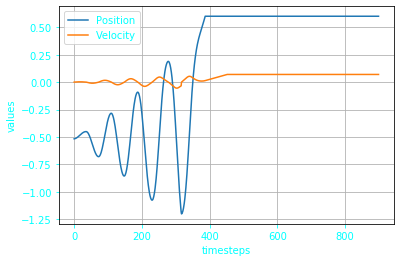

In [22]:
plt.plot(states[:, 0], label="Position")
plt.plot(states[:, 1], label="Velocity")
plt.ylabel("values")
plt.xlabel("timesteps")
plt.grid()
plt.legend()